In [32]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")

#So we can import my local libs
import CommChannel as CC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr


In [3]:
#Setup the system:

#For now, use same channel params
nPL = 4.2  
kPL = -40

decorrSH = 3.09    
alpha = 8.41
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1



#6 remote stations
qBase = np.array([[25,26], [2,2], [26,24], [48,2], [24, 24], [24,49]])
cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
#Create Comm Channels
ccs = [CC.CommChannel(cps[i], region, res) for i in range(len(cps))]
for cc in ccs:
        cc.generateSH();#cc.generateMP(2)

Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.


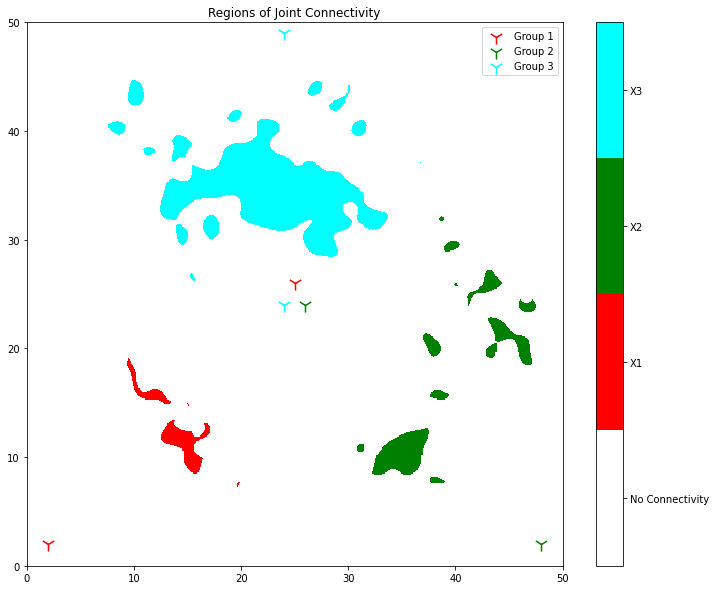

In [4]:
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 2*cfs[2]*cfs[3]; r3 = 3*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()    
plt.show()

In [5]:
def indices_to_pts(r, region, res):
    #First get the non-zero indices
    idcs = np.where(r>0)
    pts = np.array(idcs).T - [region[1], region[3]]
    pts = pts/res
    return pts, np.array(idcs).T

pts1, idcs1 = indices_to_pts(r1, region, res)
pts2, idcs2 = indices_to_pts(r2, region, res)
pts3, idcs3 = indices_to_pts(r3, region, res)

all_pts, _ = indices_to_pts(np.ones(r1.shape), region, res)

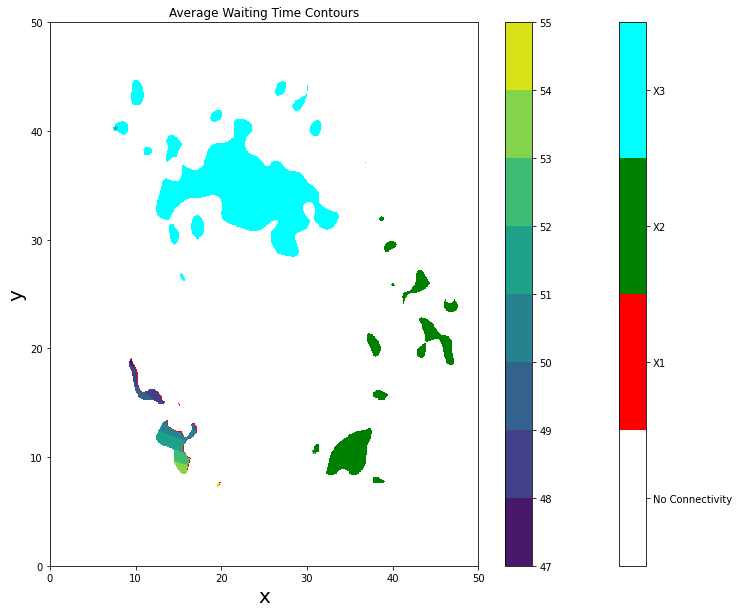

In [6]:
def XtoS(X, v = 1):
    n = len(X)
    S = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            dist = np.linalg.norm(X[i] - X[j])
            S[i,j] = dist
            S[j,i] = dist
    return S
#Setup the polling system
#TODO - reaosnable beta value?
ps = PS.PollingSystem([0.005, 0.0075, .001], 0.000001)
rp = MRP.RandomRP([1/2, 1/4, 1/4])

pt2 = pts2[0]
pt3 = pts3[0]
Z = -1*np.Inf*np.ones(r1.shape)
for i in range(len(pts1)):
    pt1 = pts1[i]
    S = XtoS([pt1, pt2, pt3])
    Z[idcs1[i,0], idcs1[i,1]] = ps.calc_avg_wait(rp, S)
    
#fig = plt.figure(figsize=(10,8))

color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 2*cfs[2]*cfs[3]; r3 = 3*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)


cont = plt.contourf(np.arange(x_min, x_max, 1/res), np.arange(y_min, y_max, 1/res), Z.T)
fig = plt.gcf()
fig.colorbar(cont)
plt.title('Average Waiting Time Contours')
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.scatter(pt2[0], pt2[1], marker='*', s=25, c='g')
plt.scatter(pt3[0], pt3[1], marker='*', s=25, c='c')
plt.show()
    

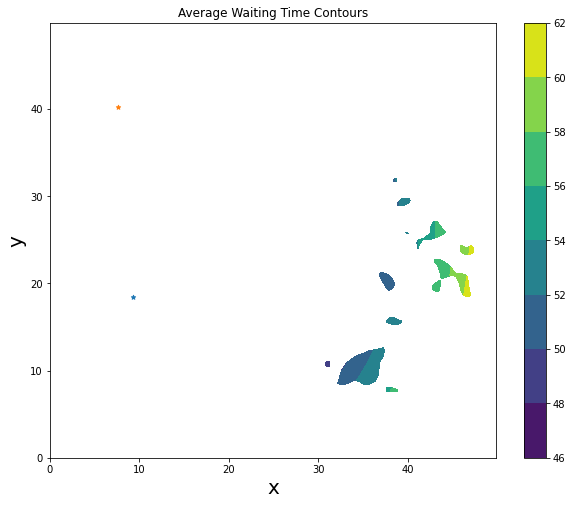

In [7]:
pt1 = pts1[0]
pt3 = pts3[0]
Z = -1*np.Inf*np.ones(r1.shape)
for i in range(len(pts2)):
    pt2 = pts2[i]
    S = XtoS([pt1, pt2, pt3])
    Z[idcs2[i,0], idcs2[i,1]] = ps.calc_avg_wait(rp, S)
    
fig = plt.figure(figsize=(10,8))
cont = plt.contourf(np.arange(x_min, x_max, 1/res), np.arange(y_min, y_max, 1/res), Z.T)
fig.colorbar(cont)
plt.title('Average Waiting Time Contours')
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.scatter(pt1[0], pt1[1], marker='*', s=20)
plt.scatter(pt3[0], pt3[1], marker='*', s=20)
plt.show()

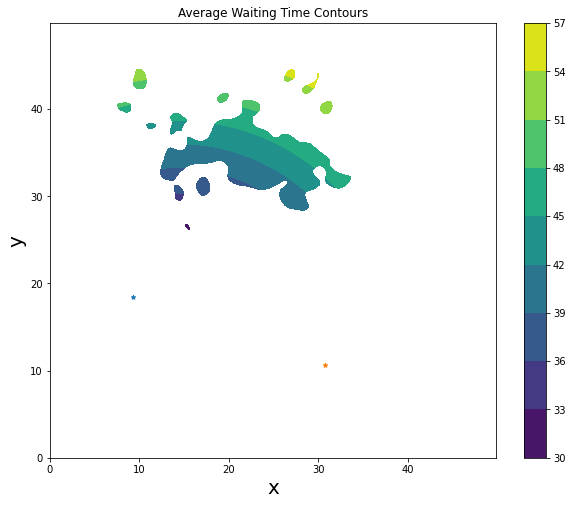

In [8]:
pt1 = pts1[0]
pt2 = pts2[0]
Z = -1*np.Inf*np.ones(r1.shape)
for i in range(len(pts3)):
    pt3 = pts3[i]
    S = XtoS([pt1, pt2, pt3])
    Z[idcs3[i,0], idcs3[i,1]] = ps.calc_avg_wait(rp, S)
    
fig = plt.figure(figsize=(10,8))
cont = plt.contourf(np.arange(x_min, x_max, 1/res), np.arange(y_min, y_max, 1/res), Z.T)
fig.colorbar(cont)
plt.title('Average Waiting Time Contours')
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.scatter(pt1[0], pt1[1], marker='*', s=20)
plt.scatter(pt2[0], pt2[1], marker='*', s=20)
plt.show()
    

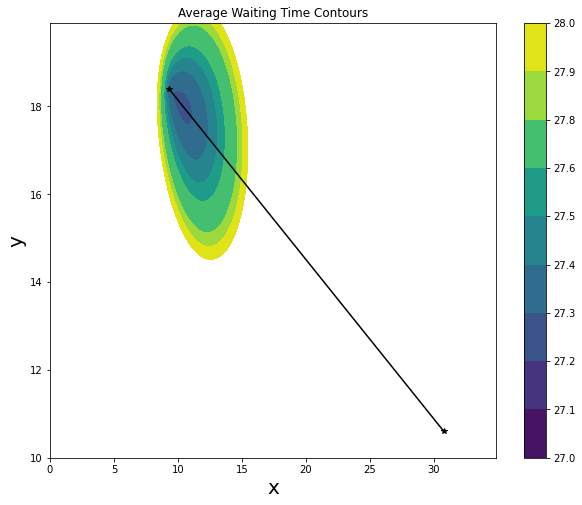

In [28]:
#Just for fun, let's see what this would look like without any boundaries
pt1 = pts1[0]
pt2 = pts2[0]
all_x = np.arange(0, 35, 1/res)
all_y = np.arange(10, 20, 1/res)
Z = np.ones((len(all_x), len(all_y)))
for i in range(len(all_x)):
    for j in range(len(all_y)):
        pt3 = [all_x[i], all_y[j]]
        S = XtoS([pt1, pt2, pt3])
        Z[i, j] = ps.calc_avg_wait(rp, S)
    
fig = plt.figure(figsize=(10,8))
cont = plt.contourf(all_x, all_y, Z.T, [27,27.1, 27.2, 27.3, 27.4, 27.5, 27.6, 27.8, 27.9, 28])
fig.colorbar(cont)
plt.title('Average Waiting Time Contours')
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]] ,'k*-')
# plt.scatter(pt1[0], pt1[1], marker='*', s=20, color='k')
# plt.scatter(pt2[0], pt2[1], marker='*', s=20, color='k')
plt.show()

In [ ]:
#from above, we see that reducing/minimizing average switching time does not always reduce average waiting time

In [44]:
import pointcloud as PC
from importlib import reload 
reload(dtr)
reload(MRP)
reload(PS)
reload(PC)

<module 'pointcloud' from '../geometry/pointcloud.py'>

Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
21 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 12 possibly non-convex polygons
38 total subregions
Extracted edges...
No Improvement, orphaned edges exist
PolyConstructor: ([29.9 43.6])  ([29.9 43.5]) 
Polygons constructed, looking for holes...
Constructed 13 possibly non-convex polygons
58 total subregions
Optimized Policy Waiting Time: 57.6688
Optimized Location Waiting Time: 56.8213


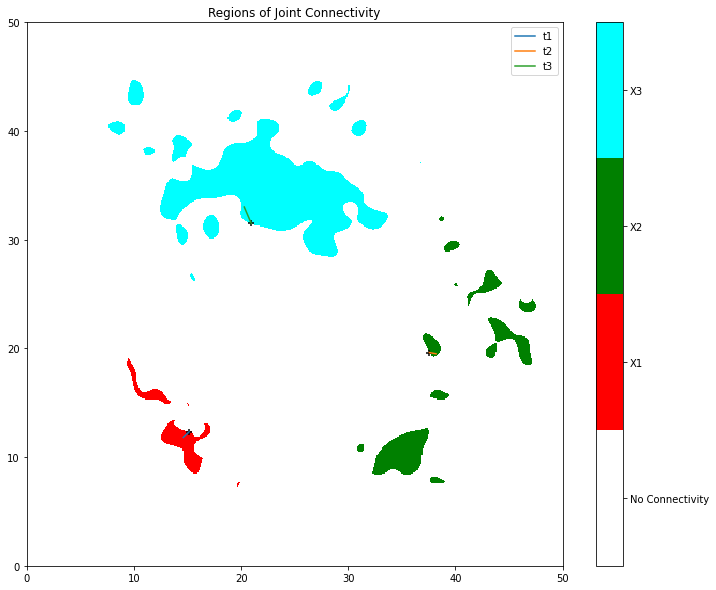

Optimized Waiting Time: 53.3730


(array([0.29169022, 0.36902236, 0.33928742]),
 array([[15.15042336, 12.32465118],
        [37.570871  , 19.61089158],
        [20.94736921, 31.49220557]]))

In [45]:
els = [0.5, 0.7, 0.5]
beta = 0.2
sys = dtr.DTR(ccs, els, beta)
sys.optimize()

Optimized Policy Waiting Time: 47.0717
Optimized Location Waiting Time: 44.8272
Optimized Policy Waiting Time: 44.2081
Optimized Location Waiting Time: 43.1632
Optimized Policy Waiting Time: 43.4516
Optimized Location Waiting Time: 41.2316
Optimized Policy Waiting Time: 41.9895
Optimized Location Waiting Time: 41.2613
Optimized Policy Waiting Time: 41.0528
Optimized Location Waiting Time: 40.7831
Optimized Policy Waiting Time: 41.0108
Optimized Location Waiting Time: 40.8624
Optimized Policy Waiting Time: 41.0948
Optimized Location Waiting Time: 40.8089
Optimized Policy Waiting Time: 41.0374
Optimized Location Waiting Time: 41.1748
Optimized Policy Waiting Time: 40.8609
Optimized Location Waiting Time: 40.7789
Optimized Policy Waiting Time: 40.6799
Optimized Location Waiting Time: 40.8443


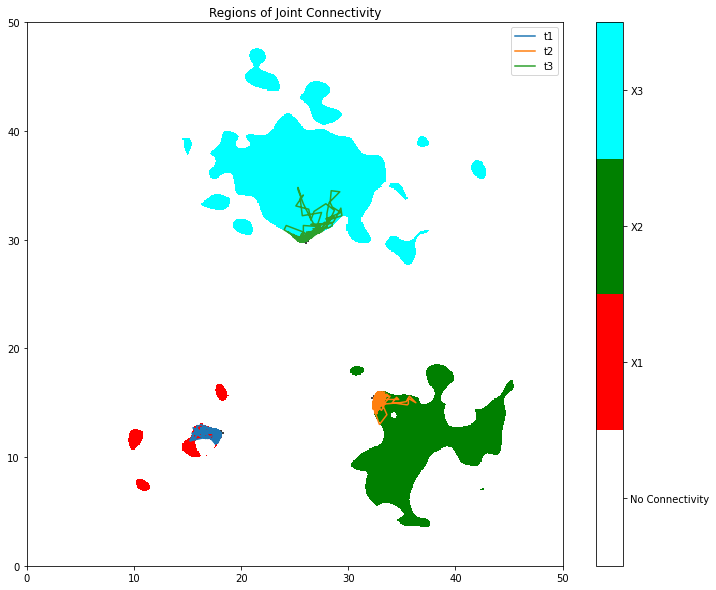

Optimized Waiting Time: 40.6696


(array([0.27066998, 0.4677942 , 0.26153582]),
 array([[18.1, 12.2],
        [32.4, 15.4],
        [26. , 29.9]]))

In [77]:
els = [0.5, 0.7, 0.5]
beta = 0.2
sys = dtr.DTR(ccs, els, beta)
sys.optimize(x_opt_method = 2)

In [46]:
for reg in sys.cregions:
    for poly in reg.polygons:
        for cnvx in poly.cnvx_partition:
            print(cnvx.to_linear_constraints())

Poly.Edge: [[19.6  7.3]
 [19.7  7.6]]
Poly.Edge: [[19.6  7.5]
 [19.7  7.6]]
Poly.Edge: [[19.6  7.3]
 [19.6  7.5]]
(array([[-3.,  1.],
       [-1.,  1.],
       [-1.,  0.]]), array([[ 51.5],
       [ 12.1],
       [-19.6]]))
Poly.Edge: [[12.2 15.3]
 [12.5 16. ]]
Poly.Edge: [[12.2 15.3]
 [12.3 15.2]]
Poly.Edge: [[12.3 15.2]
 [12.8 14.9]]
Poly.Edge: [[12.8 14.9]
 [13.3 15. ]]
Poly.Edge: [[12.5 16. ]
 [13.3 15. ]]
(array([[-2.33333333,  1.        ],
       [-1.        , -1.        ],
       [-0.6       , -1.        ],
       [ 0.2       , -1.        ],
       [-1.25      , -1.        ]]), array([[13.16666667],
       [27.5       ],
       [22.58      ],
       [12.34      ],
       [31.625     ]]))
Poly.Edge: [[ 9.3 18.4]
 [ 9.7 17.7]]
Poly.Edge: [[ 9.7 17.7]
 [10.  18. ]]
Poly.Edge: [[ 9.4 19. ]
 [10.  18. ]]
Poly.Edge: [[ 9.3 18.4]
 [ 9.4 19. ]]
(array([[-1.75      , -1.        ],
       [ 1.        , -1.        ],
       [-1.66666667, -1.        ],
       [-6.        ,  1.        ]]), a

 [29.4 32.6]]
Poly.Edge: [[26.5 31.8]
 [26.6 31.5]]
Poly.Edge: [[26.6 31.5]
 [28.6 30.5]]
Poly.Edge: [[28.6 30.5]
 [29.8 31. ]]
Poly.Edge: [[29.8 31. ]
 [30.2 31.7]]
Poly.Edge: [[29.4 32.6]
 [30.2 31.7]]
(array([[ 0.27586207, -1.        ],
       [-3.        , -1.        ],
       [-0.5       , -1.        ],
       [ 0.41666667, -1.        ],
       [-1.75      ,  1.        ],
       [-1.125     , -1.        ]]), array([[ 24.48965517],
       [111.3       ],
       [ 44.8       ],
       [ 18.58333333],
       [ 21.15      ],
       [ 65.675     ]]))
Poly.Edge: [[30.8 33.1]
 [31.3 33.4]]
Poly.Edge: [[30.8 33.1]
 [31.8 32.9]]
Poly.Edge: [[31.3 33.4]
 [31.8 32.9]]
(array([[ 0.6, -1. ],
       [-0.2, -1. ],
       [-1. , -1. ]]), array([[14.62],
       [39.26],
       [64.7 ]]))
Poly.Edge: [[17.6 33.8]
 [18.6 34.1]]
Poly.Edge: [[17.1 36.3]
 [18.6 34.1]]
Poly.Edge: [[16.6 36.3]
 [17.1 36.3]]
Poly.Edge: [[15.4 35.9]
 [16.6 36.3]]
Poly.Edge: [[15.1 35.4]
 [15.4 35.9]]
Poly.Edge: [[15.1 35.4]

In [61]:
constraint_blocks = []
b_final = np.zeros((0,1))
for reg in sys.cregions:
    n_constraints = 0
    As = np.zeros((0,2))
    bs = []
    Cs = []
       
    n_vars = 2
    for poly in reg.polygons:
        for cnvx in poly.cnvx_partition:
                n_vars += 1
                Aik,bik = cnvx.to_linear_constraints()
                As = np.concatenate((As,Aik), axis = 0)
                bs += bik.tolist()
                C = -1*10000 #actually need to find a value of this constant
                Cs.append(np.ones(len(bik))*C)
             
    n_constraints = len(bs)
    A = np.zeros((n_constraints, n_vars))
    A[:,:2] = As
    idx = 0
    for i in range(n_vars - 2):
        C = Cs[i]
        lc = len(C)
        A[idx:idx+lc, 2+i] = C
        idx += lc
    b = np.array(bs)
    
    b_final = np.concatenate((b_final, b))
    constraint_blocks.append(A)
    print('Completed Region')
    

Poly.Edge: [[19.6  7.3]
 [19.7  7.6]]
Poly.Edge: [[19.6  7.5]
 [19.7  7.6]]
Poly.Edge: [[19.6  7.3]
 [19.6  7.5]]
Poly.Edge: [[12.2 15.3]
 [12.5 16. ]]
Poly.Edge: [[12.2 15.3]
 [12.3 15.2]]
Poly.Edge: [[12.3 15.2]
 [12.8 14.9]]
Poly.Edge: [[12.8 14.9]
 [13.3 15. ]]
Poly.Edge: [[12.5 16. ]
 [13.3 15. ]]
Poly.Edge: [[ 9.3 18.4]
 [ 9.7 17.7]]
Poly.Edge: [[ 9.7 17.7]
 [10.  18. ]]
Poly.Edge: [[ 9.4 19. ]
 [10.  18. ]]
Poly.Edge: [[ 9.3 18.4]
 [ 9.4 19. ]]
Poly.Edge: [[11.1 15.9]
 [11.7 16.2]]
Poly.Edge: [[11.1 15.9]
 [12.2 15.3]]
Poly.Edge: [[12.2 15.3]
 [12.5 16. ]]
Poly.Edge: [[11.7 16.2]
 [12.5 16. ]]
Poly.Edge: [[11.  15.3]
 [12.2 15.3]]
Poly.Edge: [[11.1 15.9]
 [12.2 15.3]]
Poly.Edge: [[10.7 15.9]
 [11.1 15.9]]
Poly.Edge: [[10.7 15.9]
 [11.  15.3]]
Poly.Edge: [[ 9.9 16.5]
 [10.3 15.7]]
Poly.Edge: [[10.3 15.7]
 [10.4 16.2]]
Poly.Edge: [[10.1 16.9]
 [10.4 16.2]]
Poly.Edge: [[ 9.7 17.7]
 [10.1 16.9]]
Poly.Edge: [[ 9.7 17.7]
 [ 9.9 16.5]]
Poly.Edge: [[10.3 15.7]
 [11.  15.3]]
Poly.Edge: [

In [62]:
constraint_blocks

[array([[-3.0e+00,  1.0e+00, -1.0e+04, ...,  0.0e+00,  0.0e+00,  0.0e+00],
        [-1.0e+00,  1.0e+00, -1.0e+04, ...,  0.0e+00,  0.0e+00,  0.0e+00],
        [-1.0e+00,  0.0e+00, -1.0e+04, ...,  0.0e+00,  0.0e+00,  0.0e+00],
        ...,
        [-1.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00, -1.0e+04],
        [-1.0e+00, -1.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00, -1.0e+04],
        [-2.5e-01, -1.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00, -1.0e+04]]),
 array([[-3.33333333e-01, -1.00000000e+00, -1.00000000e+04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.00000000e+00, -1.00000000e+00, -1.00000000e+04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00, -1.00000000e+04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-4.50000000e+00, -1.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00, -1.00000000e+04],
        [ 3.333333

In [60]:
A[2+idx:2+idx+lc, 2+i]

array([0., 0., 0.])

In [63]:
import scipy.linalg as lin

In [64]:
A_final = lin.block_diag(*constraint_blocks)

In [65]:
A_final

array([[-3.e+00,  1.e+00, -1.e+04, ...,  0.e+00,  0.e+00,  0.e+00],
       [-1.e+00,  1.e+00, -1.e+04, ...,  0.e+00,  0.e+00,  0.e+00],
       [-1.e+00,  0.e+00, -1.e+04, ...,  0.e+00,  0.e+00,  0.e+00],
       ...,
       [ 0.e+00,  0.e+00,  0.e+00, ...,  0.e+00,  0.e+00, -1.e+04],
       [ 0.e+00,  0.e+00,  0.e+00, ...,  0.e+00,  0.e+00, -1.e+04],
       [ 0.e+00,  0.e+00,  0.e+00, ...,  0.e+00,  0.e+00, -1.e+04]])

In [66]:
A_final.shape

(593, 123)

In [67]:
b_final.shape

(593, 1)